In [1]:
import numpy as np
import time

#import seaborn as sns

from src.models.bocs.LinReg import LinReg
from src.models.GPr import GPr
from ngboost import NGBRegressor
from ngboost.distns import LogNormal, Normal, Exponential
from ngboost.scores import CRPS, LogScore
#from xgboost import XGBRegressor

# Learners
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

from src.problems.contamination import Contamination
from src.problems.rna import pRNA
from src.problems.bqp import BQP
from src.problems.latin_square import LatinSquare

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from src.models.bnn.bnn_engine import *


# Contamination problem

In [2]:
N = 300
opt = Contamination(n=N, lamda=0.0001)
X = opt.X
y = opt.y
test_set_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# BNN

In [10]:
hp = default_hp()
hp.lr = 1e-3
hp.patience = 100
hp.batch_size = 32
hp.epochs = 2000
model = BNN_engine.from_hparams(hp)

In [11]:
model.train(X_train, y_train, X_test, y_test, hp, verbose=True)

  0%|                                                                                                                                                                                  | 0/2000 [00:00<?, ?it/s]/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
 12%|████████████                                                                                            | 231/2000 [00:53<06:50,  4.31it/s, train_R^2=0.803, train_loss=1.99, val_R^2=0.675, val_loss=

Restoring checkpoint at step 131 with best value at 0.712
Early stopped at 131 with val_R^2=0.712


In [12]:
model.predict(X_test)

array([[1.8098211, 1.8098211, 1.8098211, ..., 1.8098211, 1.8098211,
        1.8098211],
       [1.9436257, 1.9436257, 1.9436257, ..., 1.9436257, 1.9436257,
        1.9436257],
       [1.1977806, 1.1977806, 1.1977806, ..., 1.1977806, 1.1977806,
        1.1977806],
       ...,
       [2.5172346, 2.5172346, 2.5172346, ..., 2.5172346, 2.5172346,
        2.5172346],
       [1.4124476, 1.4124476, 1.4124476, ..., 1.4124476, 1.4124476,
        1.4124476],
       [2.5517585, 2.5517585, 2.5517585, ..., 2.5517585, 2.5517585,
        2.5517585]], dtype=float32)

<Axes: >

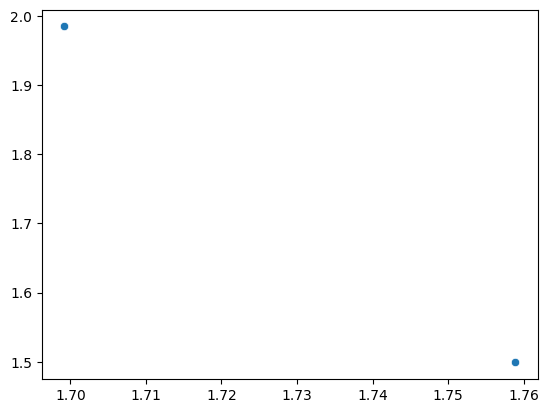

In [6]:
sns.scatterplot(x=y_test, y=y_mu)

## GP

In [12]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))


Test R^2: 1.000
Test RMSE: 0.000 units
Test MAE: 0.000 units


## BOCS

In [8]:
m2 = LinReg(nVars=25, order=2)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

Attempt Gibbs 1
Iter Gibbs 0
Iter Gibbs 100
Iter Gibbs 200
Iter Gibbs 300
Iter Gibbs 400
Iter Gibbs 500
Iter Gibbs 600
Iter Gibbs 700
Iter Gibbs 800
Iter Gibbs 900
Iter Gibbs 1000
Iter Gibbs 1100
Iter Gibbs 1200
Iter Gibbs 1300
Iter Gibbs 1400
Iter Gibbs 1500
Iter Gibbs 1600
Iter Gibbs 1700
Iter Gibbs 1800
Iter Gibbs 1900

Test R^2: 0.719
Test RMSE: 0.327 units
Test MAE: 0.266 units


In [11]:
res = m2.sample_pred(X_test)
res.shape

(40, 2000)

## NGBoost - LinCV

In [ ]:
learner = LassoCV(cv=5)
m3 = NGBRegressor(Base=learner)
m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

# RNA problem

In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
N = 20
opt = pRNA(n=N)
X = opt.X
y = opt.y
test_set_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=1)

<Axes: ylabel='Count'>

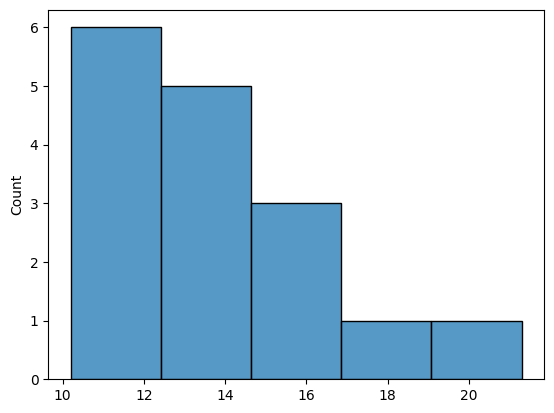

In [3]:
import seaborn as sns
sns.histplot(y_train)

# BNN

In [15]:
hp = default_hp()
hp.lr = 1e-3
hp.patience = 100
hp.batch_size = 128
hp.epochs = 2000
hp.batch_size = int(X_train.shape[0])
model = BNN_engine.from_hparams(hp)
model.train(X_train, y_train, X_test, y_test, hp, verbose=True)

  0%|                                                  | 0/2000 [00:00<?, ?it/s]/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/roinaveiro/miniconda3/envs/tf-sbbo/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
 30%|▎| 601/2000 [00:49<01:54, 12.25it/s, train_R^2=0.999, train_loss=21.8, val_

Restoring checkpoint at step 501 with best value at 0.460
Early stopped at 501 with val_R^2=0.460


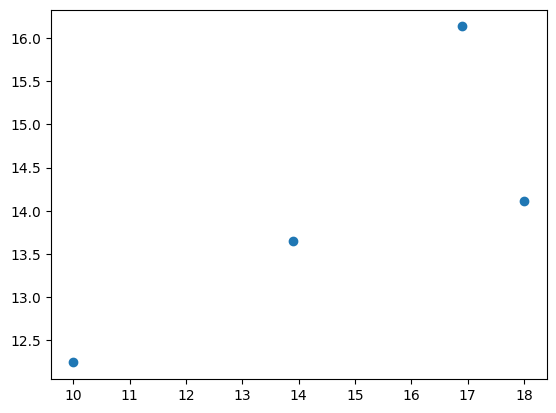

In [20]:
y_pred = model.predict(X_test)
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred.mean(axis=1))

## NGBoost - LinCV

In [12]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
m3 = NGBRegressor(Base=dec, learning_rate=0.05, verbose_eval=5, 
                  n_estimators=100, Dist=Normal)
m3.fit(X_train, y_train, X_test, y_test)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

[iter 0] loss=2.4336 val_loss=2.6130 scale=2.0000 norm=4.5043
[iter 5] loss=1.9628 val_loss=2.6384 scale=2.0000 norm=2.7669
[iter 10] loss=1.6936 val_loss=2.8314 scale=2.0000 norm=1.8562
[iter 15] loss=1.4386 val_loss=3.3869 scale=2.0000 norm=1.3815
[iter 20] loss=1.1870 val_loss=4.4861 scale=2.0000 norm=1.1535
[iter 25] loss=0.9363 val_loss=6.4579 scale=2.0000 norm=1.0534
[iter 30] loss=0.6859 val_loss=9.8360 scale=2.0000 norm=1.0154
[iter 35] loss=0.3857 val_loss=18.7983 scale=4.0000 norm=2.0033
[iter 40] loss=-0.1144 val_loss=49.9754 scale=4.0000 norm=1.9980
[iter 45] loss=-0.6145 val_loss=135.5984 scale=4.0000 norm=1.9991
[iter 50] loss=-1.1145 val_loss=369.4943 scale=4.0000 norm=1.9997
[iter 55] loss=-1.6145 val_loss=1229.1301 scale=8.0000 norm=3.9998
[iter 60] loss=-2.6145 val_loss=9093.0140 scale=8.0000 norm=4.0000
[iter 65] loss=-3.6145 val_loss=67206.0554 scale=8.0000 norm=4.0000
[iter 70] loss=-4.6145 val_loss=740861.8994 scale=16.0000 norm=8.0000
[iter 75] loss=-6.6145 val_l

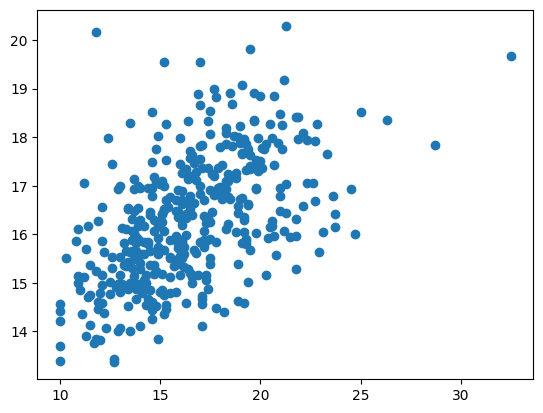

In [8]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [4]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

Metal device set to: Apple M2

Test R^2: 0.150
Test RMSE: 2.859 units
Test MAE: 2.425 units


2023-05-21 19:37:57.382053: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## BOCS

In [9]:
m2 = LinReg(nVars=90, order=2,  nGibbs=2000)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

(16, 90)
Attempt Gibbs 1
Iter Gibbs 0
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 100
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 200
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 300
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 400
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 500
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 600
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 700
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 800
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 900
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1000
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1100
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1200
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1300
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1400
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1500
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1600
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1700
Fast Small Sampler
n is 16 p is 2642
Iter Gibbs 1800
Fast Small Sample

# BQP problem

In [ ]:
N = 200
opt = BQP(n=N)
X = opt.X
y = opt.y + 10.0
test_set_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)

## NGBoost - LinCV

In [ ]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
xgb = XGBRegressor()
m3 = NGBRegressor(Base=lin)
m3 = NGBRegressor(Base=xgb, learning_rate=0.1, verbose_eval=5, n_estimators=30, Dist=Normal, Score=LogScore)

m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [ ]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## BOCS

In [ ]:
m2 = LinReg(nVars=10, order=2,  nGibbs=500)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

# Latin Square problem

In [31]:
N = 1000
opt = LatinSquare(n=N)
test_set_size = 0.2
X = opt.X
y = opt.y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=0)


Test R^2: -0.062
Test RMSE: 0.061 units
Test MAE: 0.050 units


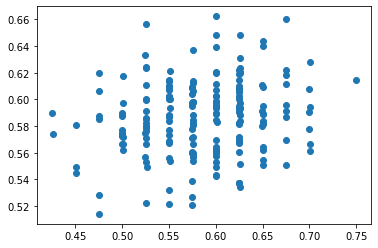

In [32]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## NGBoost - LinCV

In [33]:
linCV = LassoCV(cv=5)
lin = LinearRegression()
dec = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
xgb = XGBRegressor()
m3 = NGBRegressor(Base=lin)
m3 = NGBRegressor(Base=lin, learning_rate=0.1, verbose_eval=5, n_estimators=30, Dist=Normal, Score=LogScore)

m3.fit(X_train, y_train)

y_pred = m3.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))

[iter 0] loss=-1.4845 val_loss=0.0000 scale=0.5000 norm=0.2465
[iter 5] loss=-1.5363 val_loss=0.0000 scale=0.5000 norm=0.2239
[iter 10] loss=-1.5550 val_loss=0.0000 scale=0.5000 norm=0.2202
[iter 15] loss=-1.5639 val_loss=0.0000 scale=0.2500 norm=0.1109
[iter 20] loss=-1.5662 val_loss=0.0000 scale=0.2500 norm=0.1111
[iter 25] loss=-1.5674 val_loss=0.0000 scale=0.0625 norm=0.0278

Test R^2: -0.101
Test RMSE: 0.062 units
Test MAE: 0.050 units


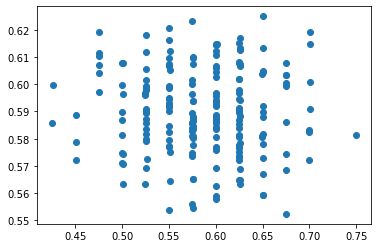

In [34]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## GP

In [35]:
m1 = GPr()
m1.fit(X_train, y_train)
y_pred = m1.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))


Test R^2: 0.035
Test RMSE: 0.058 units
Test MAE: 0.047 units


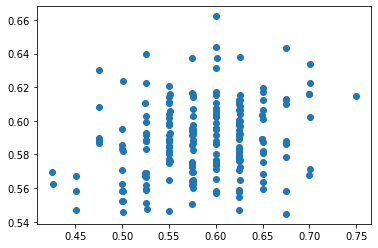

In [36]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)

## BOCS

In [ ]:
m2 = LinReg(nVars=10, order=2,  nGibbs=500)
m2.fit(X_train, y_train)
y_pred = m2.predict(X_test)

# Output R^2, RMSE and MAE on the test set
score = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\nTest R^2: {:.3f}".format(score))
print("Test RMSE: {:.3f} units".format(rmse))
print("Test MAE: {:.3f} units".format(mae))